In [1]:
# Importing packages
import torch
import os 

# Defining training and testing paths
training_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\training"
testing_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\testing"  

In [2]:
# Specifying mean and SD from imagenet dataset statistics
Mean= [0.485, 0.456, 0.406]
STD= [0.229, 0.224, 0.225]

# Specifying training hyperparameters
#Image_size=256
Image_size=1080
Batch_size= 32
#Pred_batch_size= 4
EPOCHS=16
LR=0.0001

# Determining the device type
Device= torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [3]:
# Creating the directory if it doesn't exist
os.makedirs("model_output", exist_ok=True)

# Defining paths to store trained model
VGG_Model_path= os.path.join("model_output","VGG_model.pth")
RESNET_Model_path= os.path.join("model_output","ResNet_model.pth")
MobileNet_Model_path=os.path.join("model_output","MobileNet_model.pth")

Training our Classifier


In [4]:
# Importing all the packages

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import Softmax
from torch.nn import ReLU
from torch.nn import Dropout
from torch import optim
from tqdm import tqdm
from matplotlib import pyplot as plt 
import argparse

In [5]:
# Importing the necessary packages
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Defining the dataloader function
def get_Dataloader(Dataset, Batch_size, shuffle=True):
    dl=DataLoader(Dataset,Batch_size,shuffle=shuffle)
    return dl
# Train_Val Dataset Splitter

def train_val_split(Dataset, val_split=0.2):

    total_size=len(Dataset)
    (train_idx, val_idx)= train_test_split(list(range(total_size)),test_size=val_split)

    train_set=Subset(Dataset,train_idx)
    test_set=Subset(Dataset,val_idx)

    return train_set,test_set

In [6]:
# Defining the tranform pipeline

# Create training dataset using Imagefolder
trainTransform=Compose([
    #RandomResizedCrop(Image_size),
    #RandomHorizontalFlip(),
    #RandomRotation(90),
    ToTensor(),
    Normalize(Mean, STD)
])

# Creating training dataset using Imagefolder
train_dataset=ImageFolder(training_path,trainTransform)

In [7]:
# Creating training and validation split
(TrainDataset, ValDataset)= train_val_split(Dataset=train_dataset)

# Creating training and validation data loaders
train_laoder=get_Dataloader(Dataset=TrainDataset, Batch_size=Batch_size)
val_loader=get_Dataloader(Dataset=ValDataset, Batch_size=Batch_size)

In [8]:
# Calculating Steps per epoch for training and validation set
train_step= len(TrainDataset)/Batch_size
val_step= len(ValDataset)/Batch_size

print("Train_Step: {:.2f}\nVal_step: {:.2f}".format(train_step, val_step))

#Initializing the results directory to store history for plotting
Train_Val_Hist={
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]}

Train_Step: 59.78
Val_step: 14.97


In [9]:
# Constructing an argument parser to choose between models from the command line

import sys
sys.argv=['']
del sys

ap=argparse.ArgumentParser()
ap.add_argument('-m','--model',type=str,default='resnet', choices=['vgg','resnet','mobilenet'],
                help='Name of the model')
args=vars(ap.parse_args())


In [10]:
# Defining model selection prompt and freezing training network layers to enable transfer learning. 

if args['model']=='vgg':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','vgg11',weights='VGG11_Weights.DEFAULT', skip_validation=True)

    for param in basemodel.parameters():
        param.requires_grad=False
    

elif args['model']=='resnet':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','resnet18',weights='ResNet18_Weights.DEFAULT', skip_validation=True)

    lastLayer=8
    currentLayer=1

    #Looping over the child layers of the model
    for child in basemodel.children():

        if currentLayer<lastLayer:
            for param in child.parameters():
                param.requires_grad=False
        else:
            break
        currentLayer+=1
        
elif args['model']=='mobilenet':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','mobilenet_v2',weights='MobileNet_V2_Weights.DEFAULT',skip_validation=True)       

    last_layer=2    
    current_layer=1

    #Looping over the child layers of the model
    for child in basemodel.children():
        if current_layer<last_layer:
            for param in child.parameters():
                param.requires_grad=False
        else:
            break
        current_layer+=1        


Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


In [11]:
from torchvision import models

resnet=models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
vgg16=models.vgg16_bn()
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
# # Creating the classifier for our task

# from torch.nn import Linear
# from torch.nn import Module

# class classifier(Module):
#     def __init__(self, baseModel, numclasses, model):
#         super().__init__()

#         self.baseModel=baseModel

#         if model=='vgg':
#             self.fc= Linear(baseModel.classifier[6].out_features, numclasses)
#         elif model=='resnet':
#             self.fc=Linear(baseModel.fc.out_features,numclasses)
                           
                           
# # passing the input via our basemodel to get the features and then passing through the FC layer to get out putput logits
#     def forward(self,x):
#         features=self.baseModel(x)
#         logits=self.fc(features)       
#         return logits 

In [14]:
# # Creating the classifier for our task

# from torch.nn import Linear
# from torch.nn import Module
# from torch.nn import Sequential

# class classifier(Module):
#     def __init__(self, baseModel, numclasses, model):
#         super().__init__()

#         self.baseModel=baseModel

#         if model=='vgg':
#             # num_features=baseModel.classifier[6].in_features
#             # features=list(basemodel.classifier.children())[:-1]    #Removing the last layer
#             # features.extend([Linear(num_features,numclasses)])     # Adding our new layer with 2 outputs
#             # baseModel.classifier=Sequential(*features)             # Replacing the model Claasifier
#             # Define additional convolutional layer
#             self.conv_layer = Sequential(
#                 Conv2d(512, 512, kernel_size=3, padding=1),
#                 ReLU(inplace=True)
#             )
#             self.fc= Linear(baseModel.classifier[6].out_features, numclasses)
           
#         elif model=='resnet':
#             self.fc=Linear(baseModel.fc.out_features,numclasses)
                           
                           
# # passing the input via our basemodel to get the features and then passing through the FC layer to get out putput logits
#     def forward(self,x):
#             features=self.baseModel(x)
#             logits=self.fc(features)       
#             return logits 

In [15]:
# from torch.nn import Linear, Module, Sequential, Conv2d

# class Classifier(Module):
#     def __init__(self, baseModel, numclasses, model):
#         super().__init__()
#         self.baseModel = baseModel
    
#         if model == 'vgg':
#             self.conv_layer = Sequential(
#                 Conv2d(512, 512, kernel_size=3, padding=1),
#                 ReLU(inplace=True))
            
#             self.fc = Linear(baseModel.classifier[6].out_features, numclasses)
#         elif model == 'resnet':
#             self.fc = Linear(baseModel.fc.in_features, numclasses)

#     def forward(self, x):
#         features = self.baseModel(x)
#         if hasattr(self, 'conv_layer'):
#             features = self.conv_layer(features)
#         else:
#              # Reshape the output tensor to 4D if it's not already
#             features = features.unsqueeze(2).unsqueeze(3)  # Add two dimensions   
#         x = features.view(features.size(0), -1)  # Flatten the output
#         logits = self.fc(x)
#         return logits

In [16]:
mob_net=models.MobileNetV2()
print(mob_net)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
from torch.nn import Linear, Module, Sequential, Conv2d


class Classifier(Module):
    def __init__(self, baseModel, numclasses, model):
        super().__init__()
        self.baseModel = baseModel

        if model == 'vgg':
            # Extracting the number of input features from the last layer of VGG
            num_features = baseModel.classifier[6].out_features
            
            # Defining the extra layer
            self.extra_layer1 = Linear(num_features, 512)  # Assuming 512 output features
            self.relu1 = ReLU(inplace=True)
            self.extra_layer2=Linear(512,256)
            self.relu2=ReLU(inplace=True)
            
            # Defining the final fully connected layer for classification
            self.fc = Linear(256, numclasses)  # Using the output features from the extra layer
        elif model=='resnet':
            
            self.extra_layer=Linear(baseModel.fc.out_features,256)
            self.relu=ReLU(inplace=True)

            # Defining the final fully connected layer for classification
            self.fc=Linear(256,numclasses)

        elif model=='mobilenet':

            num_features=baseModel.classifier[1].out_features

            #Defining extra layer
            self.extra_layer1=Linear(num_features,512)
            self.relu1 = ReLU(inplace=True)
            self.extra_layer2=Linear(512,256)
            self.relu2=ReLU(inplace=True)
            
            # Defining the final fully connected layer for classification
            self.fc = Linear(256, numclasses)  # Using the output features from the extra layer


        # Softmax layer for classification
        self.softmax = Softmax(dim=1)

    def forward(self, x):
        features = self.baseModel(x)
        
        # Applying the extra layer and ReLU activation
        if 'vgg' in self.baseModel.__class__.__name__.lower():
            features = self.extra_layer1(features)
            features=self.relu1(features)
            features=self.extra_layer2(features)
            features = self.relu2(features)

        elif 'resnet' in self.baseModel.__class__.__name__.lower():
            #Applying the extra layer and ReLu activation
            features=self.extra_layer(features)
            features=self.relu(features)    

        elif 'mobilenet' in self.baseModel.__class__.__name__.lower():  
            features = self.extra_layer1(features)
            features=self.relu1(features)
            features=self.extra_layer2(features)
            features = self.relu2(features)

        
        # Passing the features through the final fully connected layer
        logits = self.fc(features)
        output=self.softmax(logits)
        return output        
        

In [18]:
# Building the custom model
model= Classifier(baseModel=basemodel.to(Device),numclasses=2,model=args["model"])
model=model.to(Device)

# Initializing loss function and optimizer
loss_func= CrossEntropyLoss()
loss_func=loss_func.to(Device)
optimizer=optim.Adam(model.parameters(), lr=LR)

# Initializing the softmax activation layer
activation_func= Softmax()

In [19]:
print(model)

Classifier(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [20]:
# Setting up the training epoch 
print("[INFO] Training the Network")

for e in range(EPOCHS):
    model.train()
    
    total_train_loss=0 # initializing the loss and accuracy metrics
    train_correct=0

    total_val_loss=0
    val_correct=0

#looping over training set and sending to device:
    for (image,targets) in tqdm(train_laoder):
        (image, targets)=image.to(Device), targets.to(Device)
                 
        #logits=model(image)   
        logits=model(image)                                            #performing forward pass and calculating loss
        loss= loss_func(logits,targets)
        optimizer.zero_grad()                                             #Zeroing out the gradient 
        loss.backward()                                                   #Back propogation    
        optimizer.step()                                                  #updating the weights

        total_train_loss += loss.item()                                   # Adding loss to the total loss training

        #pred=activation_func(logits)
        pred=logits                                      # Pass the logits via Softmax functions to obtain predictions

        train_correct += (pred.argmax(dim=-1)== targets).sum().item()     # Calculating the total number of correct predictionsq        


# Evaluating val dataset
    
    #Swithching off autograd and setting it to eval mode.
    with torch.no_grad():
        model.eval()

        for (image,targets) in tqdm(val_loader):
            (image, targets)= image.to(Device),targets.to(Device)

            #logits=model(image)
            logits=model(image) 
            loss=loss_func(logits, targets)
            total_val_loss += loss.item()

            #pred=activation_func(logits)
            pred=logits
            val_correct += (pred.argmax(dim=-1)==targets).sum().item()


    # Calculating Avg. loss and accuracy

    Avg_train_Loss= total_train_loss/ train_step
    Avg_val_loss= total_val_loss /val_step
        
    train_correct=train_correct/len(train_dataset)
    val_correct=val_correct/len(ValDataset)

    #Updating training history
    Train_Val_Hist["train_loss"].append(Avg_train_Loss)
    Train_Val_Hist["train_acc"].append(train_correct)
    Train_Val_Hist["val_loss"].append(Avg_val_loss)
    Train_Val_Hist["val_acc"].append(val_correct)
    
    # Printing training and validation info        

    print(f"[INFO] EPOCH: {e+1}/{EPOCHS}")
    print(f"Train_loss: {Avg_train_Loss:.4f}, Train_Accuracy: {train_correct:.3f}")
    print(f"Val_loss: {Avg_val_loss:.4f}, Val_Accuracy: {val_correct:.3f}")


[INFO] Training the Network


100%|██████████| 15/15 [06:58<00:00, 27.91s/it]


[INFO] EPOCH: 1/16
Train_loss: 0.4077, Train_Accuracy: 0.732
Val_loss: 0.3304, Val_Accuracy: 0.987


  0%|          | 0/60 [00:40<?, ?it/s]


KeyboardInterrupt: 

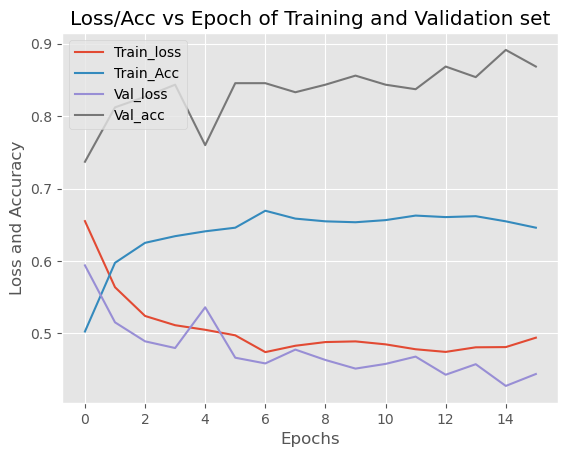

In [ ]:
%matplotlib inline

plt.style.use("ggplot")
plt.figure()
plt.title("Loss/Acc vs Epoch of Training and Validation set")

plt.plot(Train_Val_Hist["train_loss"],label="Train_loss")
plt.plot(Train_Val_Hist["train_acc"],label="Train_Acc")
plt.plot(Train_Val_Hist["val_loss"],label="Val_loss")
plt.plot(Train_Val_Hist["val_acc"],label="Val_acc")

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.legend(loc="best")

plt.show()


In [ ]:
if args['model']=='vgg':
    torch.save(model.state_dict(), VGG_Model_path)
elif args['model']=='resnet':
    torch.save(model.state_dict(), RESNET_Model_path)    
elif args['model']=='mobilenet':
    torch.save(model.state_dict(), MobileNet_Model_path )   